<a href="https://colab.research.google.com/github/OriRoth22/tierra_spec_task/blob/main/tierra_spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install dependencies

In [53]:
!git clone https://github.com/OriRoth22/tierra_spec_task.git


Cloning into 'tierra_spec_task'...


In [55]:
!cp /content/tierra_spec.ipynb /content/tierra_spec_task/


cp: cannot stat '/content/tierra_spec.ipynb': No such file or directory


In [ ]:
!pip install pystac-client
!pip install odc-stac
!pip install rioxarray
!pip install netCDF4
!pip install rasterio
!pip install planetary-computer


I took the polygon true color image from google earth for convoneont reasons, to see where we are focusing

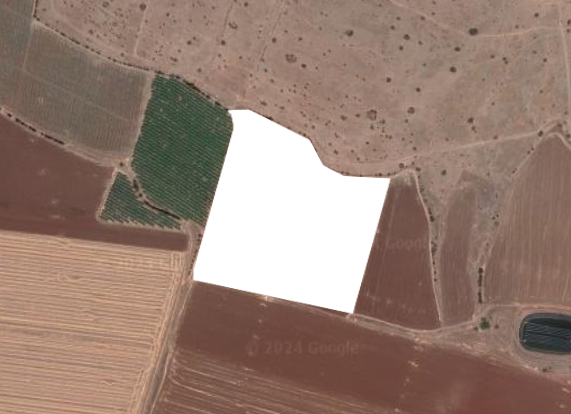

#import data
downlad scence that containe the polygon, with filtering of cloud cover less then 30% ( can be djusted)


filter time - 1 march 24  to 1th april 24



In [41]:
"""
Created on Tue Jan  7 10:39:01 2025

@author: Ori
"""
from shapely.geometry import box, Polygon

import pystac_client
import planetary_computer
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
from shapely.geometry import shape
from shapely.geometry import box
import geopandas as gpd
import numpy as np
from pystac.extensions.eo import EOExtension as eo
import odc.stac

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

polygon_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [35.425319654, 32.566444657],
            [35.425263411, 32.566480554],
            [35.425629751, 32.566491813],
            [35.4267837, 32.566000681],
            [35.427050295, 32.565594612],
            [35.427458434, 32.565414986],
            [35.428331729, 32.565377635],
            [35.427650177, 32.563207762],
            [35.424608773, 32.563749924],
            [35.424609093, 32.563881124],
            [35.425375536, 32.566217865],
            [35.425319654, 32.566444657],
        ]
    ],
}
time_of_interest = "2024-03-01/2024-04-01"

search = catalog.search(
    collections=["landsat-c2-l2"], # search the landset 8/ 9 data
    intersects=polygon_geojson,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 30}}, # max 30% cloud cover
)

items = search.item_collection() # get list of the item founded
print(f"Returned {len(items)} Items")
print (items)




Returned 4 Items


# clipping the data anf filterind high NDVI scenes

now we want to remove scences with vegetation beacuse we want bare soil,

we are using the NDVI parameter (seee https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index)

to calc that we need to fucos on the polygon, so taking the bands needed of the polygon
we want to filter out items that thier polygon




Processing item: LC08_L2SP_174038_20240328_02_T1 from 2024-03-28 08:10:41.748584+00:00
Mean NDVI for LC08_L2SP_174038_20240328_02_T1: 0.160509116942605


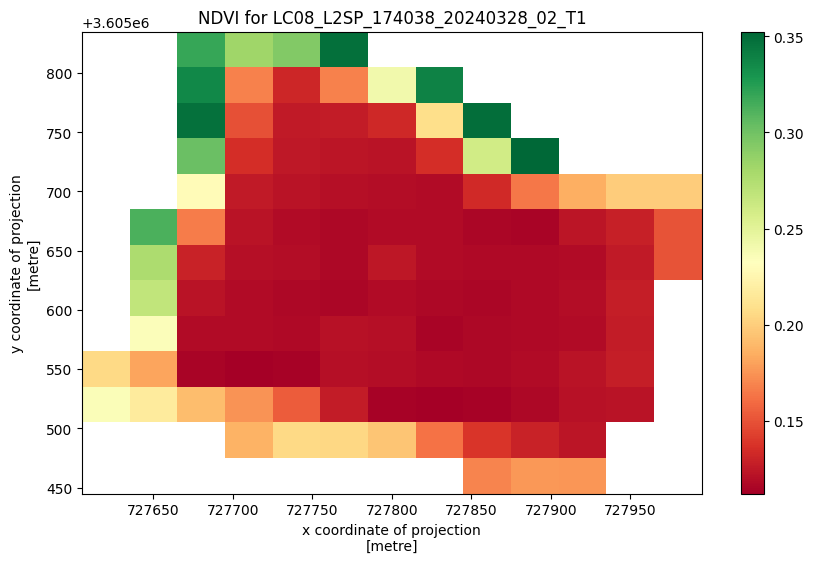

Processing item: LC09_L2SP_174038_20240320_02_T1 from 2024-03-20 08:11:14.999496+00:00
Mean NDVI for LC09_L2SP_174038_20240320_02_T1: 2.7553238453981415
Item LC09_L2SP_174038_20240320_02_T1 removed due to high mean NDVI (2.7553238453981415).
Processing item: LC08_L2SP_174038_20240312_02_T1 from 2024-03-12 08:10:57.080467+00:00
Mean NDVI for LC08_L2SP_174038_20240312_02_T1: 0.1249263104826448


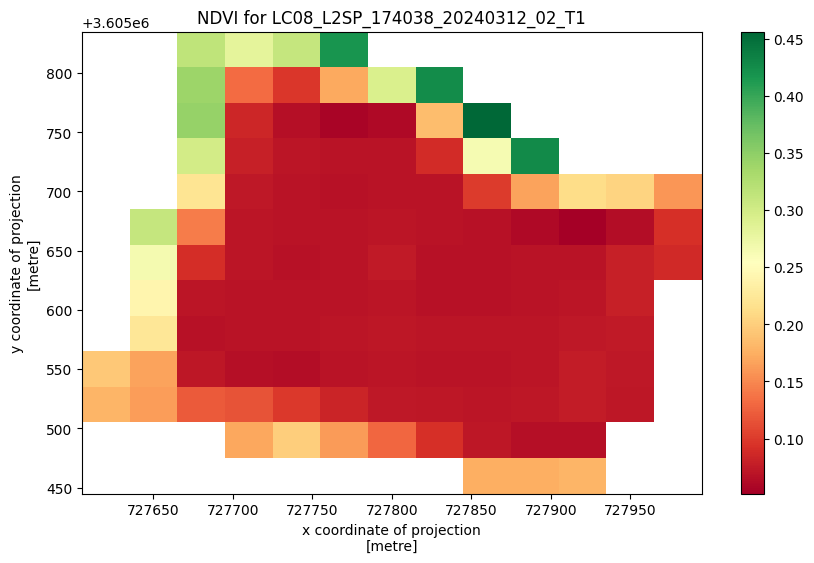

Processing item: LC08_L2SP_174037_20240312_02_T1 from 2024-03-12 08:10:33.189428+00:00
Mean NDVI for LC08_L2SP_174037_20240312_02_T1: 0.12457907413057061


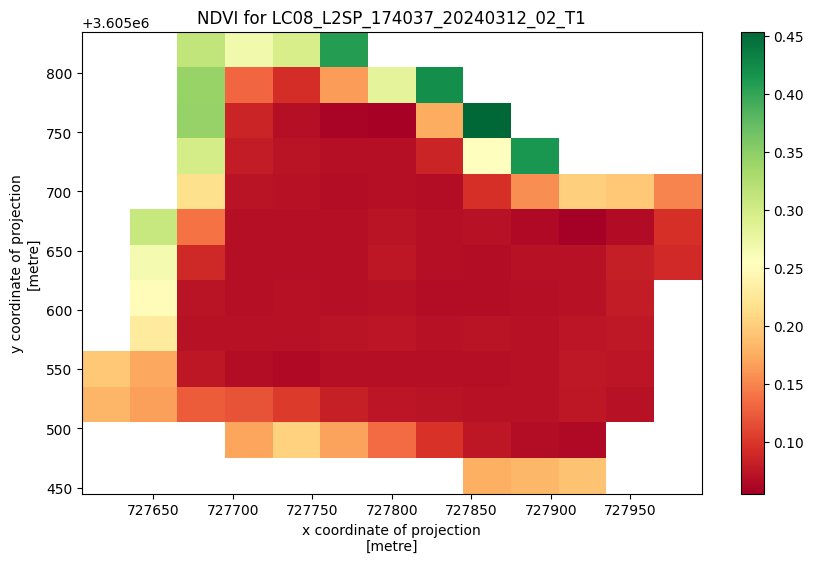

Processing complete.
3 items retained after filtering.


In [42]:
# Convert polygon to a GeoDataFrame
polygon_gdf = gpd.GeoDataFrame(geometry=[shape(polygon_geojson)], crs="EPSG:4326")

# Function to calculate NDVI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red)

# Initialize storage for NDVI results
ndvi_results = {}
filtered_items = []  # Store items that meet the mean NDVI

for item in items:
    print(f"Processing item: {item.id} from {item.datetime}")

    # Load the data for the needed bands
    bands_of_interest = ["red", "nir08"]
    data = odc.stac.stac_load([item], bands=bands_of_interest).isel(time=0)

    # Clip the data to the polygon
    clipped_data = data.rio.clip([polygon_gdf.geometry[0]], polygon_gdf.crs, all_touched=True)

    # Calculate NDVI
    red_band = clipped_data["red"]
    nir_band = clipped_data["nir08"]
    ndvi = calculate_ndvi(nir_band, red_band)

    # Calculate mean NDVI
    mean_ndvi = ndvi.mean().item()  # Convert xarray DataArray to a scalar value
    print(f"Mean NDVI for {item.id}: {mean_ndvi}")

    # Check the mean NDVI threshold
    if mean_ndvi <= 0.2:
        filtered_items.append(item)  # Keep items with mean NDVI <= 0.2
        ndvi_results[item.id] = ndvi

        # Visualize NDVI (optional)
        plt.figure(figsize=(10, 6))
        ndvi.plot(cmap="RdYlGn")
        plt.title(f"NDVI for {item.id}")
        plt.show()
    else:
        print(f"Item {item.id} removed due to high mean NDVI ({mean_ndvi}).")

print("Processing complete.")
print(f"{len(filtered_items)} items retained after filtering.")


# clipping the data anf filterind high HASE scenes:
now we want to remove days with high haze parimeters, so doing the same-
download the needed bands clipped to the polygon , calc the haze and remove over haze days


Processing item for haze: LC08_L2SP_174038_20240328_02_T1 from 2024-03-28 08:10:41.748584+00:00
Mean HOT for LC08_L2SP_174038_20240328_02_T1: 0.35424691352484505
Mean Blue-to-Red Ratio for LC08_L2SP_174038_20240328_02_T1: 0.9755185696351987


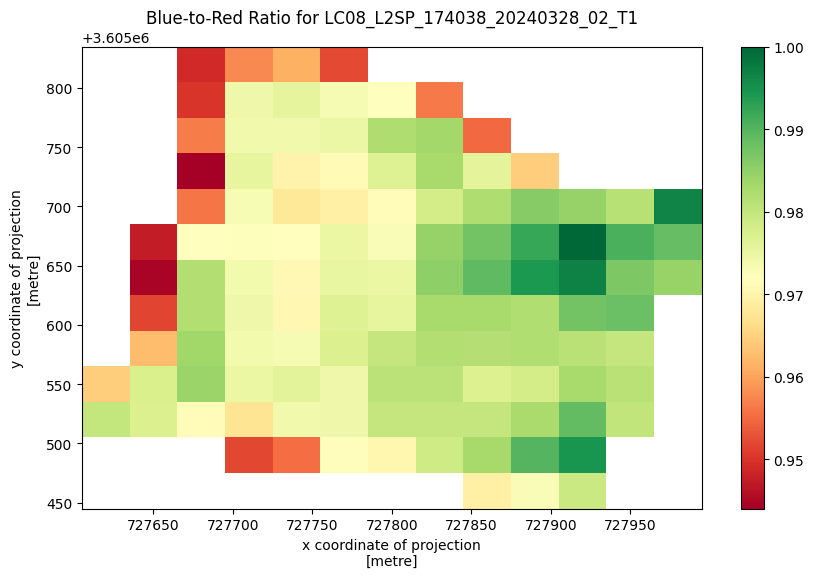

Item LC08_L2SP_174038_20240328_02_T1 removed due to haze (HOT=0.35424691352484505, Ratio=0.9755185696351987).
Processing item for haze: LC08_L2SP_174038_20240312_02_T1 from 2024-03-12 08:10:57.080467+00:00
Mean HOT for LC08_L2SP_174038_20240312_02_T1: 0.35675094483680087
Mean Blue-to-Red Ratio for LC08_L2SP_174038_20240312_02_T1: 0.9623832308829791


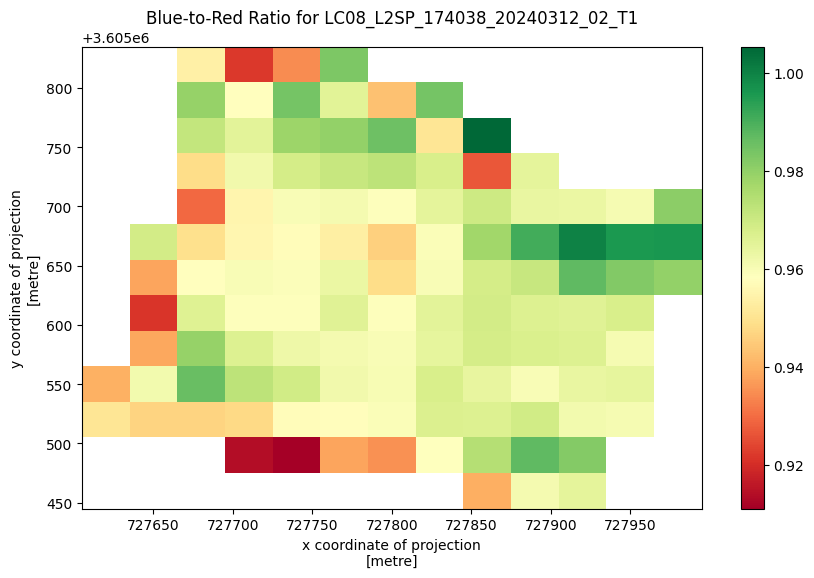

Item LC08_L2SP_174038_20240312_02_T1 removed due to haze (HOT=0.35675094483680087, Ratio=0.9623832308829791).
Processing item for haze: LC08_L2SP_174037_20240312_02_T1 from 2024-03-12 08:10:33.189428+00:00
Mean HOT for LC08_L2SP_174037_20240312_02_T1: 0.352866089576894
Mean Blue-to-Red Ratio for LC08_L2SP_174037_20240312_02_T1: 0.9738719465005659


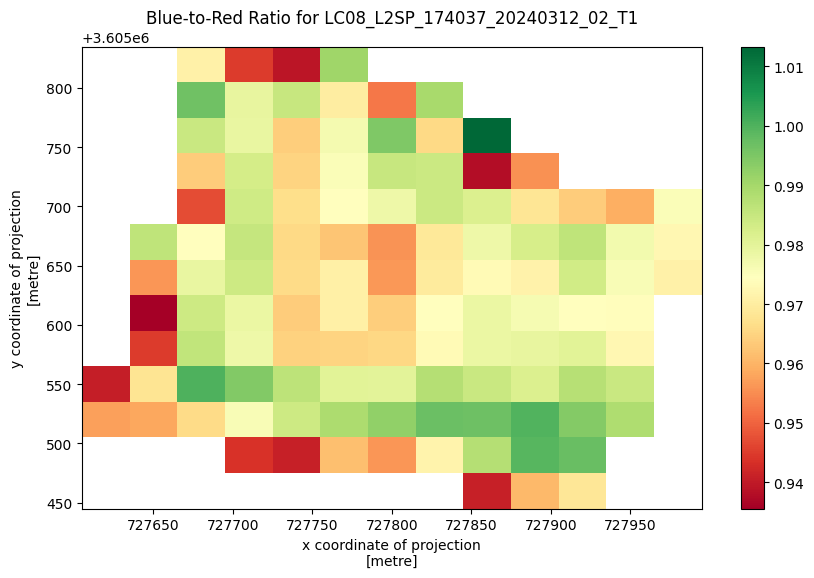

Item LC08_L2SP_174037_20240312_02_T1 removed due to haze (HOT=0.352866089576894, Ratio=0.9738719465005659).
0 items retained after haze filtering.


In [46]:
# Function to normalize band values
def normalize_band(band, max_value=None):
    # Compute dynamic max if not provided
    if max_value is None:
        max_value = band.max().item()
    return band / max_value

# Define clipping threshold (if necessary)
CLIPPING_THRESHOLD = 10000

# Loop through filtered items
for item in filtered_items:  # Use only NDVI-filtered items
    print(f"Processing item for haze: {item.id} from {item.datetime}")

    # Load the data for the required bands
    bands_of_interest = ["red", "blue"]
    data = odc.stac.stac_load([item], bands=bands_of_interest).isel(time=0)

    # Clip the data to the polygon
    clipped_data = data.rio.clip([polygon_gdf.geometry[0]], polygon_gdf.crs, all_touched=True)

    # Clip values to threshold and normalize
    red_band = clipped_data["red"].where(clipped_data["red"] <= CLIPPING_THRESHOLD, CLIPPING_THRESHOLD)
    blue_band = clipped_data["blue"].where(clipped_data["blue"] <= CLIPPING_THRESHOLD, CLIPPING_THRESHOLD)

    # Normalize using dynamic max values
    normalized_red_band = normalize_band(red_band)
    normalized_blue_band = normalize_band(blue_band)

    # Calculate HOT and Blue-to-Red Ratio
    hot = calculate_hot(normalized_red_band, normalized_blue_band)
    blue_red_ratio = blue_to_red_ratio(normalized_blue_band, normalized_red_band)

    # Calculate mean HOT and Blue-to-Red Ratio
    mean_hot = hot.mean().item()
    mean_blue_red_ratio = blue_red_ratio.mean().item()
    print(f"Mean HOT for {item.id}: {mean_hot}")
    print(f"Mean Blue-to-Red Ratio for {item.id}: {mean_blue_red_ratio}")

    # Visualize Blue-to-Red Ratio (optional)
    plt.figure(figsize=(10, 6))
    blue_red_ratio.plot(cmap="RdYlGn")
    plt.title(f"Blue-to-Red Ratio for {item.id}")
    plt.show()

    # Check thresholds for haze
    if mean_hot <= HOT_THRESHOLD and mean_blue_red_ratio <= BLUE_RED_RATIO_THRESHOLD:
        final_filtered_items.append(item)
        haze_results[item.id] = {
            "HOT": mean_hot,
            "Blue-to-Red Ratio": mean_blue_red_ratio
        }
    else:
        print(f"Item {item.id} removed due to haze (HOT={mean_hot}, Ratio={mean_blue_red_ratio}).")

print(f"{len(haze_results)} items retained after haze filtering.")


# choose the latest day
now we have the scences filtered, so just choose the latest day

In [9]:
# Select the item with the latest date
if final_filtered_items:
    selected_item = max(final_filtered_items, key=lambda item: item.datetime)
    print(f"Latest item: {selected_item.id} from {selected_item.datetime}")
else:
    print("No items remaining after filtering.")




print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)


max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")


polygon = Polygon(polygon_geojson['coordinates'][0])  # Convert GeoJSON to Shapely polygon

Latest item: LC08_L2SP_174038_20240328_02_T1 from 2024-03-28 08:10:41.748584+00:00
Choosing LC08_L2SP_174038_20240328_02_T1 from 2024-03-28 with 1.65% cloud cover
              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (j

# plot the polygon:
we git the scence obtained at  2024-03-28 08:10:41
lets plot plygon of true color to see that we are looking on a good data

In [34]:
print (selected_item)
date= selected_item.datetime.date()
print (date)

<Item id=LC08_L2SP_174038_20240328_02_T1>
2024-03-28


#lets plot just to see if we are in on the rigth place


/usr/local/lib/python3.10/dist-packages/xarray/core/duck_array_ops.py:228: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


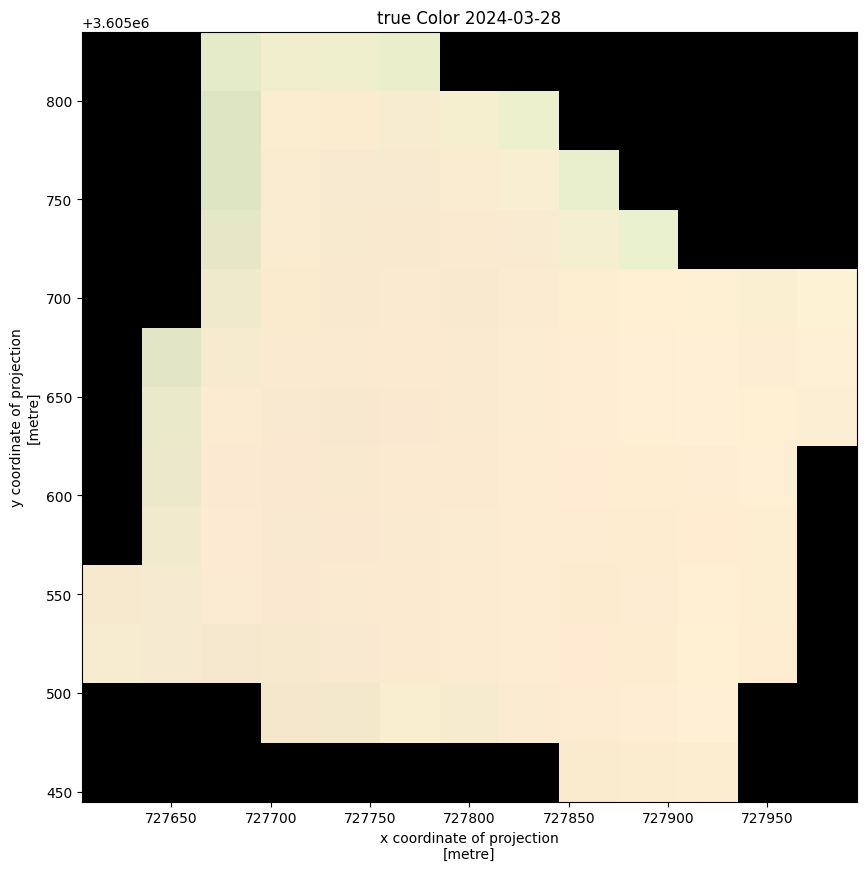

In [59]:
import matplotlib.pyplot as plt
from shapely.geometry import shape
import geopandas as gpd
import rioxarray
import planetary_computer

# Convert your polygon GeoJSON to a GeoDataFrame
polygon_gdf = gpd.GeoDataFrame(geometry=[shape(polygon_geojson)], crs="EPSG:4326")
bbox = polygon.bounds  # Get the bounding box coordinates (min_lon, min_lat, max_lon, max_lat)

# Load the data with the bounding box of interest, including all bands
# patch_url signs the URLs, preventing the 403 error
data = odc.stac.stac_load(
    [selected_item],
    bands=None,  # Load all available bands
    bbox=bbox,
    patch_url=planetary_computer.sign
).isel(time=0)

# Clip the data to the polygon
clipped_data = data.rio.clip([polygon_gdf.geometry[0]], polygon_gdf.crs, all_touched=True)

# Plotting all bands is typically not practical, so we'll focus on a subset
# For demonstration, let's plot the "Natural Color" (RGB) image
# Adjust the bands used based on the available bands in your data
rgb_bands = ["red", "green", "blue"]

# Extract the RGB bands and plot
rgb_data = clipped_data[rgb_bands].to_array()
fig, ax = plt.subplots(figsize=(10, 10))
rgb_data.plot.imshow(robust=True, ax=ax)
ax.set_title(f'true Color {date}');
plt.show()

# Now we have have 'clipped_data' which contains all the bands, clipped to your polygon


In [52]:
clipped_data.to_netcdf('clipped_data.nc', format='NETCDF4')
data.to_netcdf('data.nc', format='NETCDF4')

# save as csv file

download the bands i want to undserstand what scal ethey used

In [26]:
import rioxarray as rxr
import numpy as np


# Clip the data using the polygon geometry
clipped_data = data.rio.clip([polygon_gdf.geometry[0]], polygon_gdf.crs, all_touched=True)

# Extract the desired bands (red, green, blue)
rgb_bands = data[["red", "green", "blue"]]

# Save each band as a separate CSV file
for band_name, band_data in rgb_bands.data_vars.items():
    output_filename = f"{band_name}_band2.csv"
    np.savetxt(output_filename, band_data.data, delimiter=",")

print("Saved clipped red, green, and blue bands to CSV files.")

Saved clipped red, green, and blue bands to CSV files.


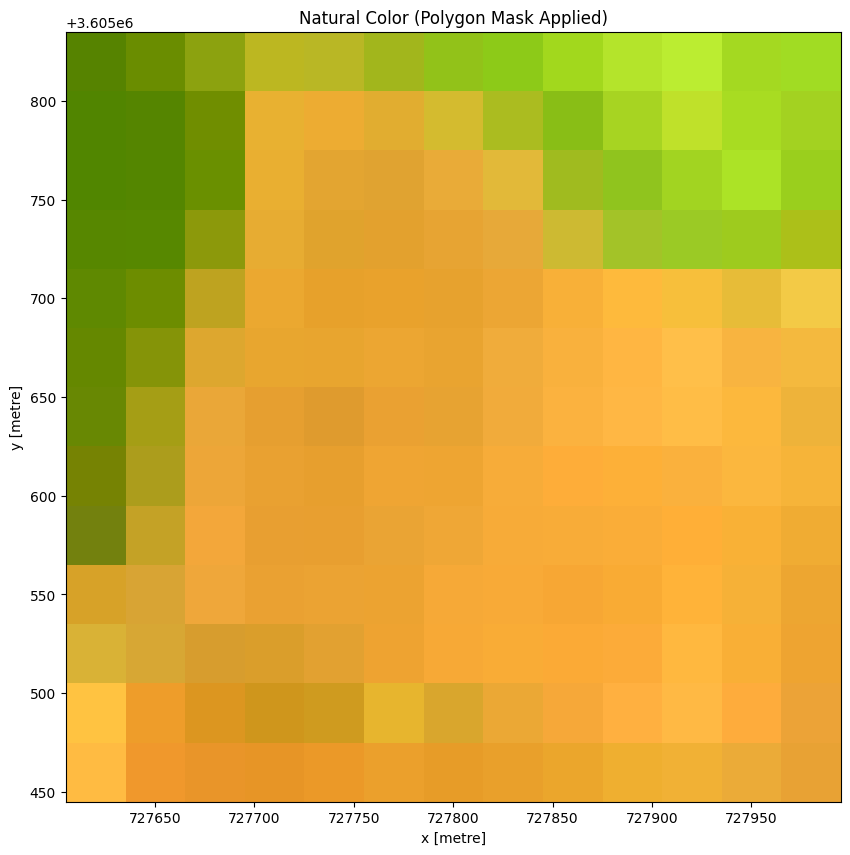

In [27]:
masked_data = data.where(clipped_data.notnull())

fig, ax = plt.subplots(figsize=(10, 10))
masked_data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color (Polygon Mask Applied)");
plt.show()
